# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7745695572639495185
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14388123713365419648
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 17:18:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'VGG16'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 5
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4"
T_all_labels = "T0", "T1", "T2", "T3", "T4"

#base_path = ''
base_path = 'gdrive/My Drive/Research_5_1_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_VGG16_None S_VGG16_imagenet T_VGG16_None T_VGG16_imagenet


['S_VGG16_imagenet', 'S_VGG16_None', 'T_VGG16_imagenet', 'T_VGG16_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2274, 128, 128, 3) (2274, 1)
(758, 128, 128, 3) (758, 1)
(758, 128, 128, 3) (758, 1)

(2034, 128, 128, 3) (2034, 1)
(678, 128, 128, 3) (678, 1)
(678, 128, 128, 3) (678, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2274, 128, 128, 3) (2274, 5)
(758, 128, 128, 3) (758, 5)
(758, 128, 128, 3) (758, 5)

(2034, 128, 128, 3) (2034, 5)
(678, 128, 128, 3) (678, 5)
(678, 128, 128, 3) (678, 5)


## 2-2. Image Check

xTrain_S image Numbers :  2274
xTrain_S image Numbers // 10 :  227
11


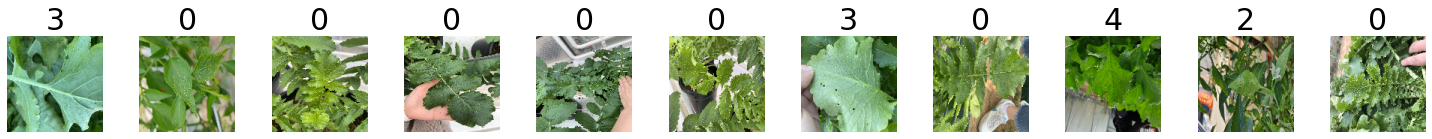

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2034
xTrain_S image Numbers // 10 :  203
11


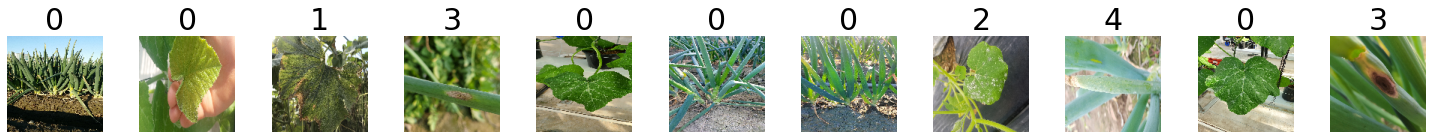

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.VGG16 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.VGG16 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 21s 267ms/step - loss: 3.0106 - accuracy: 0.3342 - val_loss: 1.4524 - val_accuracy: 0.3958
Epoch 2/100
36/36 [==============================] - 5s 145ms/step - loss: 1.4605 - accuracy: 0.3958 - val_loss: 1.4499 - val_accuracy: 0.3958
Epoch 3/100
36/36 [==============================] - 5s 145ms/step - loss: 1.4528 - accuracy: 0.3958 - val_loss: 1.4484 - val_accuracy: 0.3958
Epoch 4/100
36/36 [==============================] - 5s 148ms/step - loss: 1.4521 - accuracy: 0.3958 - val_loss: 1.4549 - val_accuracy: 0.3958
Epoch 5/100
36/36 [==============================] - 5s 145ms/step - loss: 1.4494 - accuracy: 0.3958 - val_loss: 1.4515 - val_accuracy: 0.3958
Epoch 6/100
36/36 [==============================] - 5s 145ms/step - loss: 1.4518 - accuracy: 0.3958 - val_loss: 1.4483 - val_accuracy: 0.3958
Epoch 7/100
36/36 [==============================] - 5s 145ms/step - loss: 1.4521 - accuracy: 0.3958 - val_loss: 1.4482 - val_accuracy: 0.395

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,3.010640,0.334213,1.452438,0.395778
1,1.460538,0.395778,1.449940,0.395778
2,1.452850,0.395778,1.448353,0.395778
3,1.452112,0.395778,1.454919,0.395778
4,1.449385,0.395778,1.451461,0.395778
5,1.451794,0.395778,1.448270,0.395778
6,1.452093,0.395778,1.448236,0.395778
7,1.449597,0.395778,1.448176,0.395778
8,1.450381,0.395778,1.447997,0.395778
9,1.449152,0.395778,1.451862,0.395778


Minimum validation loss: 1.4476768970489502
Maximum validation accuracy: 0.3957783579826355


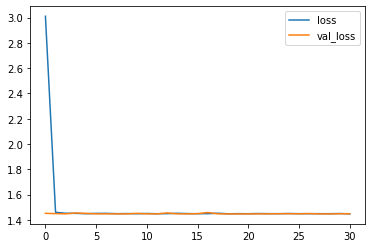

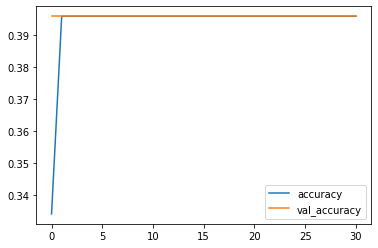

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
24/24 [==============================] - 2s 60ms/step - loss: 1.4525 - accuracy: 0.3958
test loss, test acc: [1.452451467514038, 0.3957783579826355]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

24/24 [==============================] - 1s 21ms/step


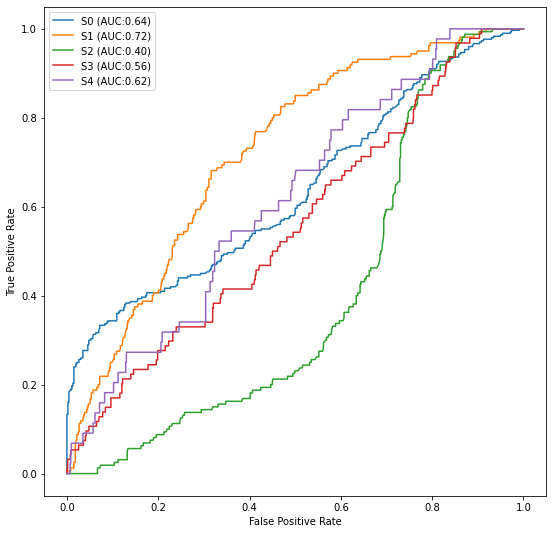

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

58900480/58889256 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 7s 158ms/step - loss: 4.1076 - accuracy: 0.3531 - val_loss: 1.4747 - val_accuracy: 0.3958
Epoch 2/100
36/36 [==============================] - 5s 147ms/step - loss: 1.4316 - accuracy: 0.3993 - val_loss: 1.3262 - val_accuracy: 0.4208
Epoch 3/100
36/36 [==============================] - 5s 147ms/step - loss: 1.3357 - accuracy: 0.4354 - val_loss: 1.3431 - val_accuracy: 0.4617
Epoch 4/100
36/36 [==============================] - 5s 146ms/step - loss: 1.2576 - accuracy: 0.4692 - val_loss: 1.1836 - val_accuracy: 0.4894
Epoch 5/100
36/36 [==============================] - 5s 145ms/step - loss: 1.2027 - accuracy: 0.4631 - val_loss: 1.1508 - val_accuracy: 0.4842
Epoch 6/100
36/36 [==============================] - 5s 146ms/step - loss: 1.1680 - accuracy: 0.5000 - val_loss: 1.1164 - val_accuracy: 0.5185
Epoch 7/100
36/36 [==============================] - 5s 147ms/step - loss: 1.2080 - accuracy: 0.4771 - val_loss: 1.3273 - val_accuracy: 0.5211

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,4.107638,0.353122,1.474716,0.395778
1,1.431571,0.399296,1.326244,0.420844
2,1.335732,0.435356,1.343052,0.461741
3,1.257586,0.469217,1.183590,0.489446
4,1.202741,0.463061,1.150777,0.484169
...,...,...,...,...
57,0.022656,0.994283,0.813413,0.823219
58,0.076411,0.975814,0.855593,0.792876
59,0.180897,0.939314,0.630969,0.807388
60,0.083816,0.973615,0.724624,0.820580


Minimum validation loss: 0.5217443704605103
Maximum validation accuracy: 0.8416886329650879


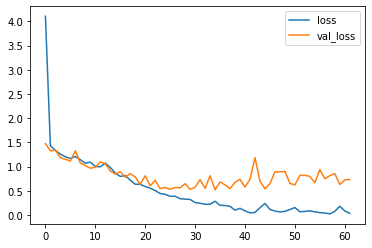

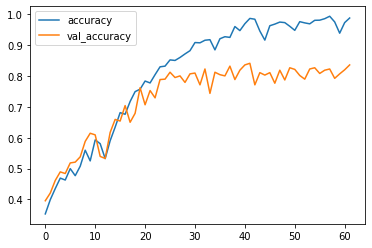

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
24/24 [==============================] - 1s 24ms/step - loss: 0.8212 - accuracy: 0.8417
test loss, test acc: [0.8212047815322876, 0.8416886329650879]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

24/24 [==============================] - 1s 21ms/step


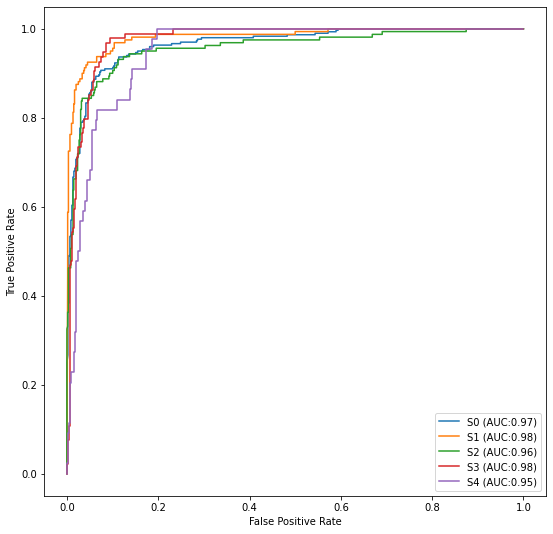

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 10s 283ms/step - loss: 1.5353 - accuracy: 0.3289 - val_loss: 1.4031 - val_accuracy: 0.4425
Epoch 2/100
32/32 [==============================] - 5s 145ms/step - loss: 1.4546 - accuracy: 0.4425 - val_loss: 1.4307 - val_accuracy: 0.4425
Epoch 3/100
32/32 [==============================] - 5s 146ms/step - loss: 1.3446 - accuracy: 0.4425 - val_loss: 1.5011 - val_accuracy: 0.4425
Epoch 4/100
32/32 [==============================] - 5s 146ms/step - loss: 1.2521 - accuracy: 0.4425 - val_loss: 1.3293 - val_accuracy: 0.4425
Epoch 5/100
32/32 [==============================] - 5s 145ms/step - loss: 1.2103 - accuracy: 0.4425 - val_loss: 1.1767 - val_accuracy: 0.4425
Epoch 6/100
32/32 [==============================] - 5s 147ms/step - loss: 1.1440 - accuracy: 0.5005 - val_loss: 1.1351 - val_accuracy: 0.5413
Epoch 7/100
32/32 [==============================] - 5s 146ms/step - loss: 1.1222 - accuracy: 0.5329 - val_loss: 1.0726 - val_accuracy: 0.541

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.535350,0.328909,1.403149,0.442478
1,1.454639,0.442478,1.430716,0.442478
2,1.344629,0.442478,1.501133,0.442478
3,1.252090,0.442478,1.329323,0.442478
4,1.210268,0.442478,1.176716,0.442478
...,...,...,...,...
95,0.095830,0.970010,0.509884,0.876106
96,0.075016,0.975418,0.353123,0.910029
97,0.030469,0.991642,0.393473,0.905605
98,0.009439,0.997050,0.465457,0.917404


Minimum validation loss: 0.293599396944046
Maximum validation accuracy: 0.9262536764144897


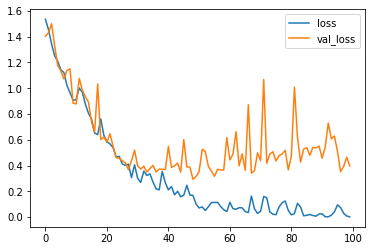

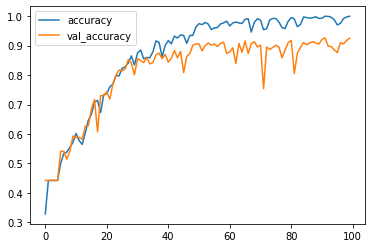

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
22/22 [==============================] - 1s 38ms/step - loss: 0.5003 - accuracy: 0.9204
test loss, test acc: [0.5003299117088318, 0.9203540086746216]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

22/22 [==============================] - 1s 21ms/step


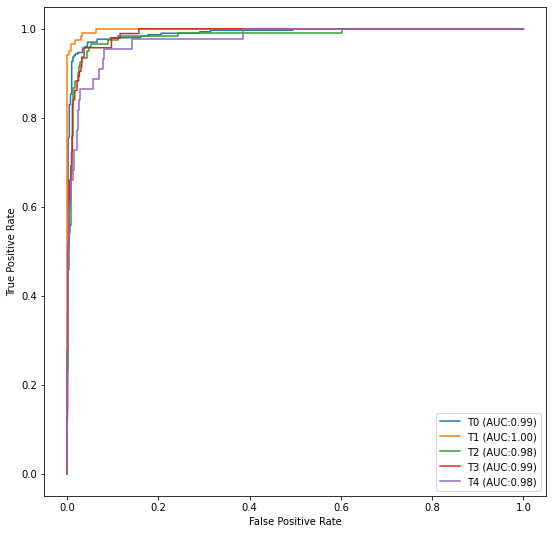

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 6s 157ms/step - loss: 1.9543 - accuracy: 0.4120 - val_loss: 1.4183 - val_accuracy: 0.4425
Epoch 2/100
32/32 [==============================] - 5s 148ms/step - loss: 1.4065 - accuracy: 0.4425 - val_loss: 1.3322 - val_accuracy: 0.4469
Epoch 3/100
32/32 [==============================] - 5s 148ms/step - loss: 1.2794 - accuracy: 0.4916 - val_loss: 1.3253 - val_accuracy: 0.5118
Epoch 4/100
32/32 [==============================] - 5s 148ms/step - loss: 1.2119 - accuracy: 0.5408 - val_loss: 1.1125 - val_accuracy: 0.5634
Epoch 5/100
32/32 [==============================] - 5s 148ms/step - loss: 1.0639 - accuracy: 0.5988 - val_loss: 1.0410 - val_accuracy: 0.5826
Epoch 6/100
32/32 [==============================] - 5s 148ms/step - loss: 0.9489 - accuracy: 0.6318 - val_loss: 1.0160 - val_accuracy: 0.5855
Epoch 7/100
32/32 [==============================] - 5s 148ms/step - loss: 0.8246 - accuracy: 0.6608 - val_loss: 0.8042 - val_accuracy: 0.6829

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,1.954300,0.411996,1.418278,0.442478
1,1.406472,0.442478,1.332244,0.446903
2,1.279350,0.491642,1.325269,0.511799
3,1.211936,0.540806,1.112536,0.563422
4,1.063872,0.598820,1.040993,0.582596
...,...,...,...,...
72,0.000005,1.000000,0.377738,0.945428
73,0.000004,1.000000,0.398296,0.946903
74,0.000003,1.000000,0.410793,0.943953
75,0.000003,1.000000,0.434028,0.948378


Minimum validation loss: 0.16321593523025513
Maximum validation accuracy: 0.9572271108627319


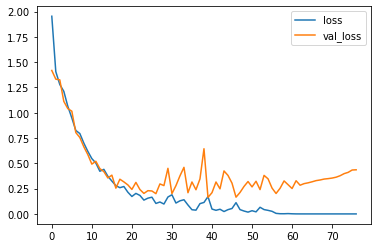

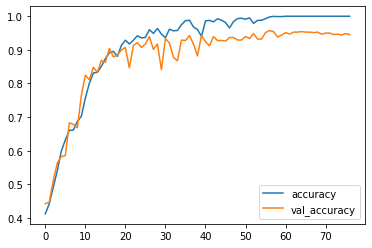

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
22/22 [==============================] - 1s 22ms/step - loss: 0.2074 - accuracy: 0.9440
test loss, test acc: [0.2073800414800644, 0.9439527988433838]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

22/22 [==============================] - 1s 21ms/step


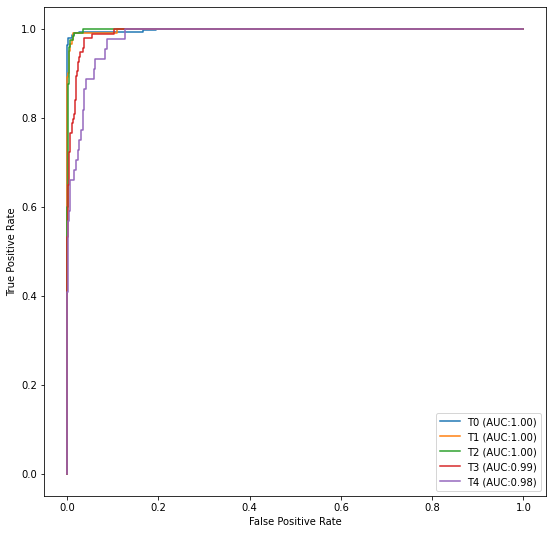

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_VGG16_None
test loss, test acc: [1.452451467514038, 0.3957783579826355]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_VGG16_imagenet
test loss, test acc: [0.8212047815322876, 0.8416886329650879]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_VGG16_None
test loss, test acc: [0.5003299117088318, 0.9203540086746216]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_VGG16_imagenet
test loss, test acc: [0.2073800414800644, 0.9439527988433838]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_VGG16_None →→→ Target Test
22/22 [==============================] - 1s 23ms/step - loss: 1.4369 - accuracy: 0.4425
test loss, test acc: [1.4369041919708252, 0.44247788190841675]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_VGG16_imagenet →→→ Target Test
22/22 [==============================] - 1s 23ms/step - loss: 6.9957 - accuracy: 0.4100
test loss, test acc: [6.995734214782715, 0.41002950072288513]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_VGG16_None →→→ Source Test
24/24 [==============================] - 1s 23ms/step - loss: 8.3116 - accuracy: 0.3206
test loss, test acc: [8.311583518981934, 0.32058048248291016]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_VGG16_imagenet →→→ Source Test
24/24 [==============================] - 1s 23ms/step - loss: 5.8406 - accuracy: 0.2361
test loss, test acc: [5.840558052062988, 0.23614776134490967]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )